In [11]:
# Import Packages and setup
import logging
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)
logger = logging.getLogger("proxmin")
logger.setLevel(logging.DEBUG)

import time

#import autograd.numpy as np
import numpy as np
import scarlet
import scarlet.display
from scarlet.display import AsinhMapping, img_to_rgb
from scarlet.operators_pybind11 import get_valid_monotonic_pixels, linear_interpolate_invalid_pixels
from scarlet.detect import wavelet_deblend, initialize_objects, initialize_peaks, peaks_to_objects
from scarlet.wavelet import starlet_transform, get_multiresolution_support
from scarlet import detect_pybind11

from astropy.table import Table as ApTable
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
#matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
prop_cycle = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
blends = scarlet.testing.api.get_blend_ids(3)
parent = blends[0]
data = scarlet.testing.api.get_blend(parent)
images = data["images"]
variance = data["variance"]
weights = 1/data["variance"]
mask = data["footprint"]
weights = weights * ~mask
psf = scarlet.ImagePSF(data["psfs"])
centers = data["centers"]

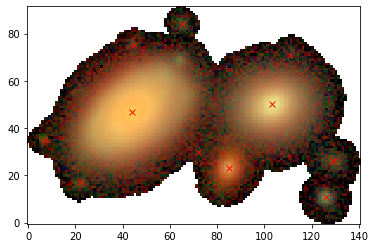

In [3]:
stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
rgb = scarlet.display.img_to_rgb(images, norm=norm, mask=mask)
plt.imshow(rgb, origin="lower")
for center in centers:
    plt.plot(center[1], center[0], "rx")
plt.show()

In [4]:
filters = "grizy"
model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters), boxsize=15)

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

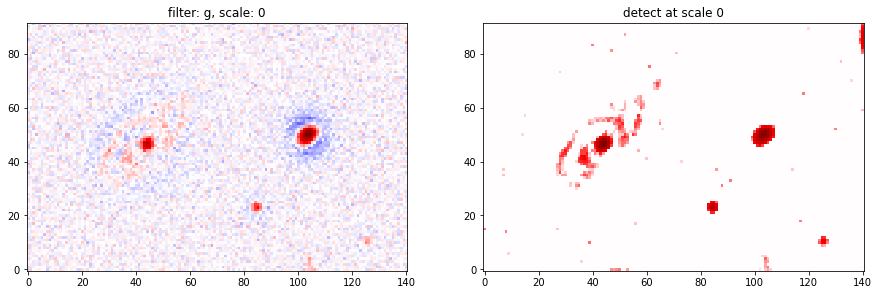

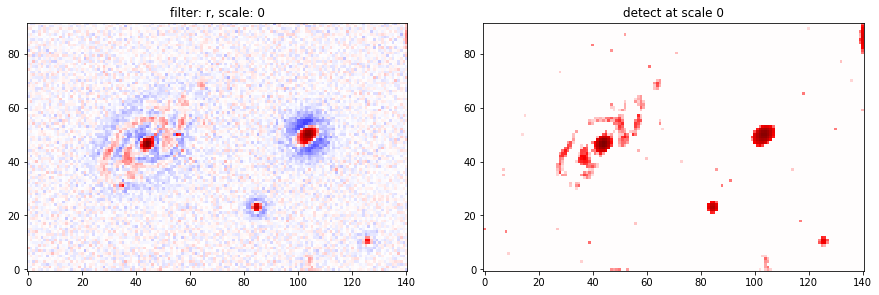

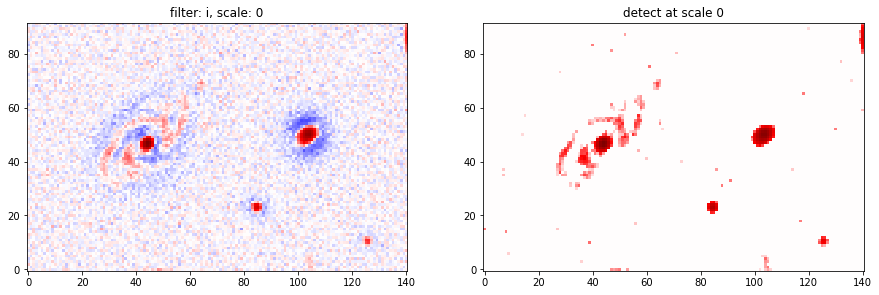

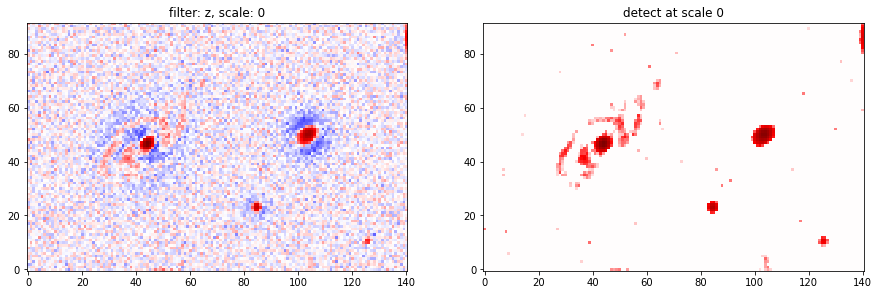

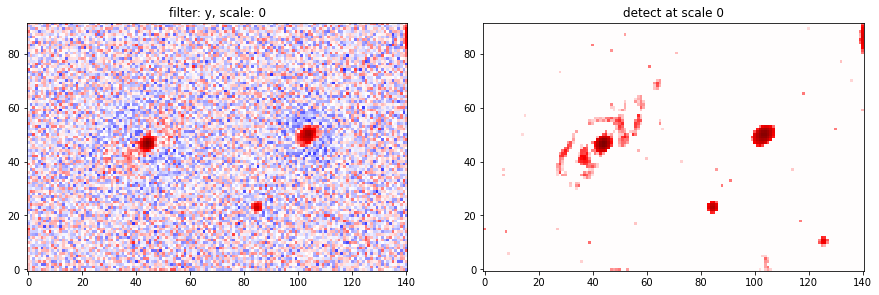

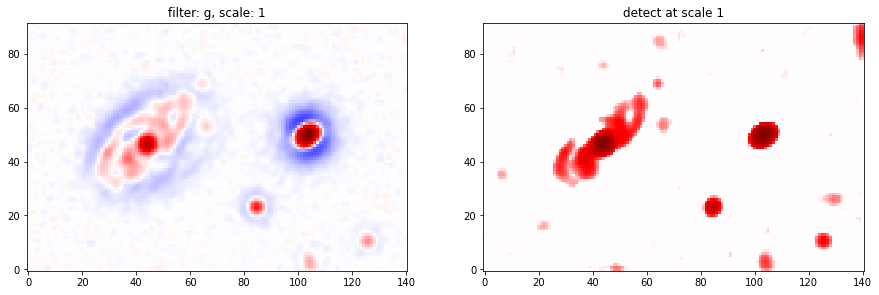

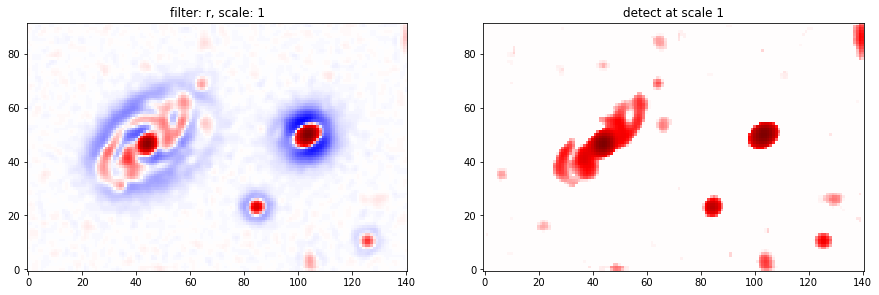

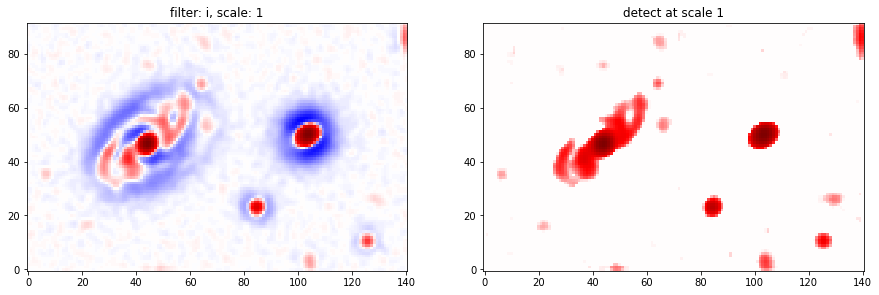

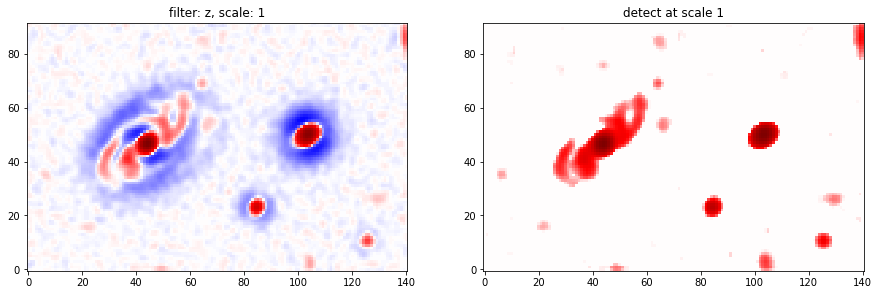

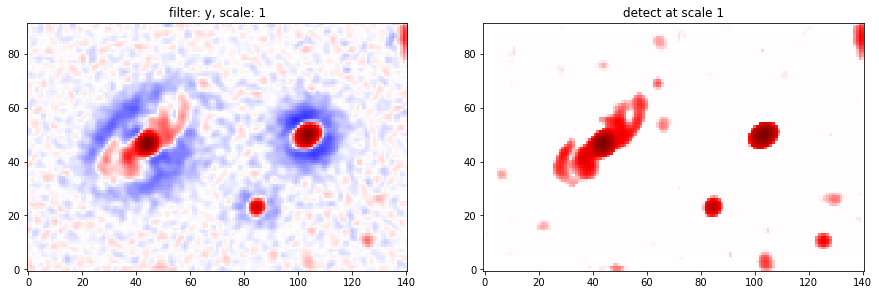

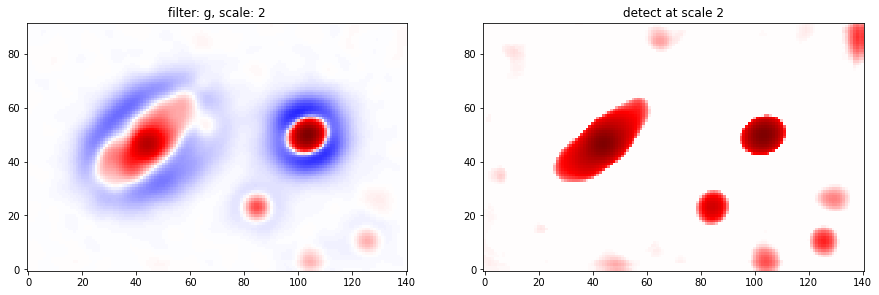

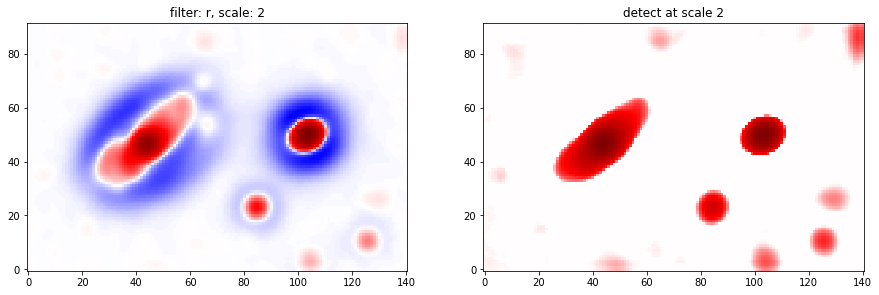

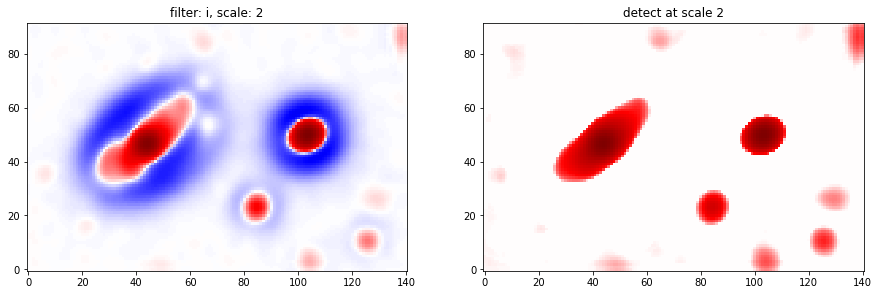

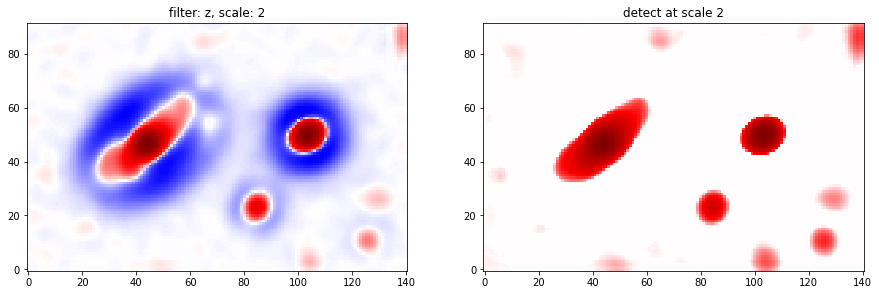

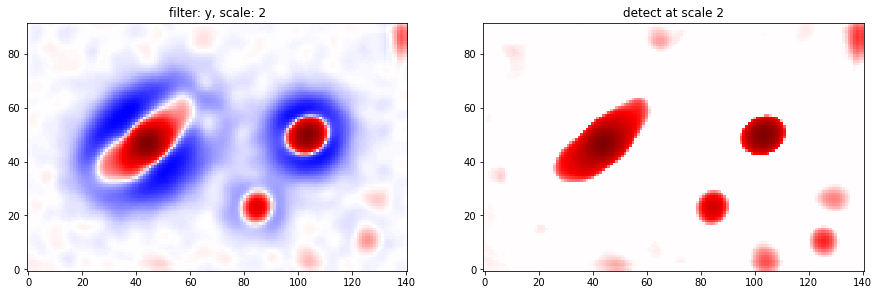

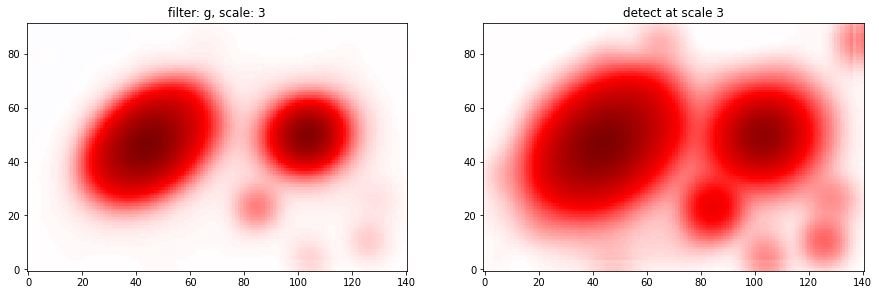

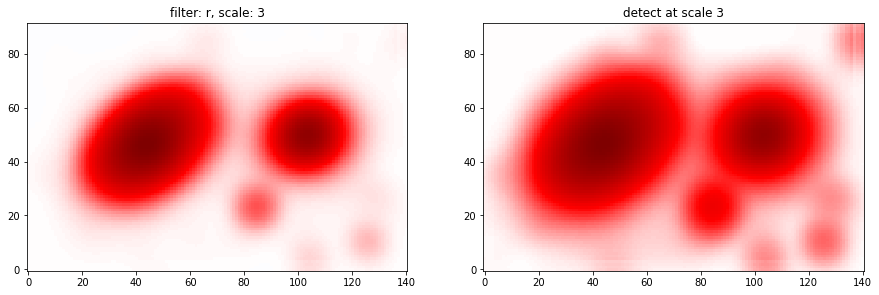

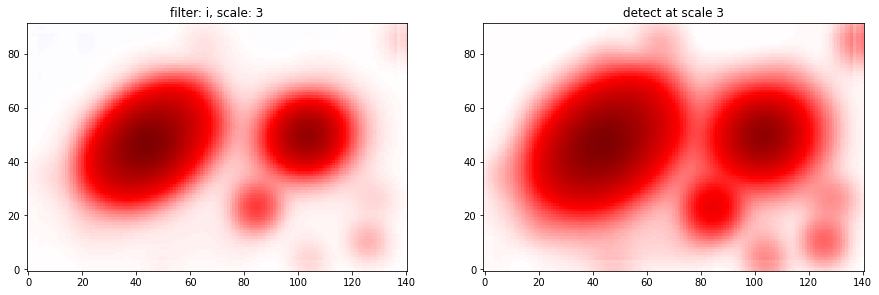

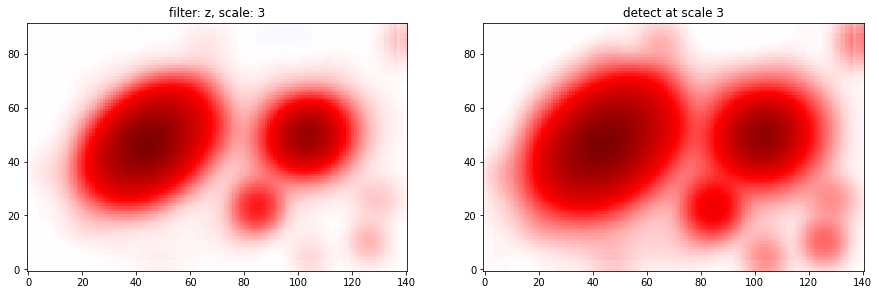

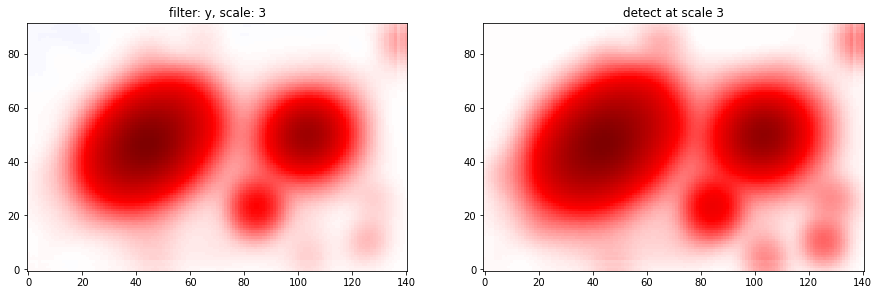

In [160]:
def arcsinh_plot(image, ax=None, stretch=10, figsize=(8, 8)):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    im = np.arcsinh(stretch*image)/stretch
    vmax = np.max(np.abs(im))
    ax.imshow(im, vmin=-vmax, vmax=vmax, cmap="seismic", origin="lower")

sigma = np.median(np.sqrt(variance), axis=(1,2))
wavelets = np.empty((4,)+images.shape)
detect = np.empty((4,)+images.shape)
for b, image in enumerate(images):
    coeffs = scarlet.wavelet.starlet_transform(image, scales=3, generation=1)
    wavelets[:, b] = coeffs
    coeffs = scarlet.wavelet.starlet_transform(image, scales=3)
    M = get_multiresolution_support(image, coeffs, sigma[b], K=3, epsilon=1e-1, max_iter=20)
    detect[:, b] = M*coeffs

detect = np.sum(detect, axis=1)

for scale, obs in enumerate(wavelets):
    for b, w in enumerate(obs):
        d = detect[scale]
        d[d<0] = 0
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        arcsinh_plot(w, ax[0])
        arcsinh_plot(d, ax[1])
        ax[0].set_title(f"filter: {filters[b]}, scale: {scale}")
        ax[1].set_title(f"detect at scale {scale}")
        plt.show()

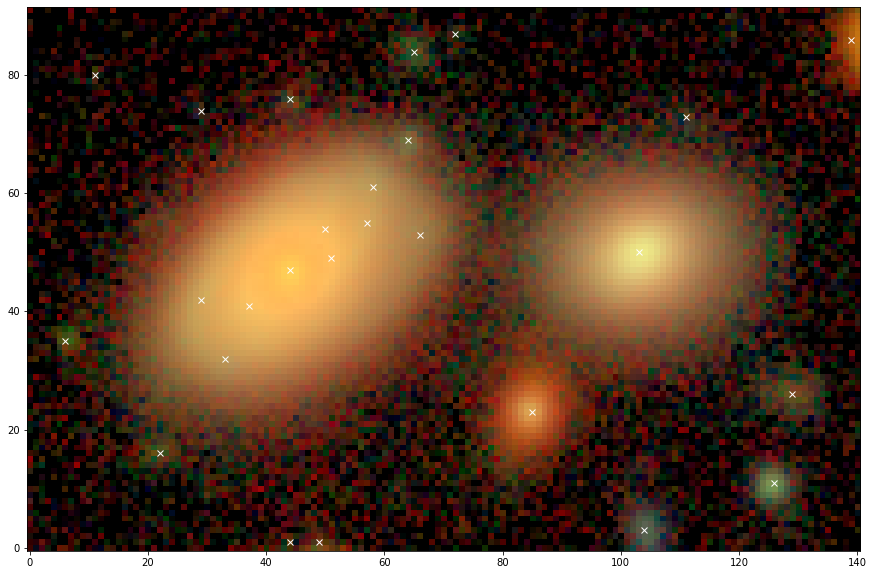

In [161]:
scale = 1
footprints = detect_pybind11.get_footprints(detect[1], min_separation=3, min_area=4, thresh=0)
peaks = []
for fp in footprints:
    peaks += [(peak.y, peak.x) for peak in fp.peaks]


stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.figure(figsize=(15,10))
plt.imshow(rgb, origin="lower")
for center in peaks:
    plt.plot(center[1], center[0], "wx")
plt.show()

In [162]:
from scarlet.component import FactorizedComponent
from scarlet.morphology import ExtendedSourceMorphology
from scarlet.initialization import get_pixel_spectrum, trim_morphology
from scarlet.operator import prox_monotonic_tree
from scarlet.spectrum import TabulatedSpectrum

class MultiScaleSource(FactorizedComponent):
    def __init__(self, model_frame, sky_coord, observations, detect, center_radius=1,
                 variance=0.0, max_iter=3, step_scale=0):
        # get center pixel spectrum
        # this is from convolved image: weighs higher emission *and* narrow PSF
        spectra = np.array(get_pixel_spectrum(sky_coord, observations))[0]/3000
        
        center = model_frame.get_pixel(sky_coord)
        
        valid, morph, bounds = prox_monotonic_tree(
            detect, 0,
            center=center,
            center_radius=center_radius,
            variance=variance,
            max_iter=max_iter,
        )
        
        center_index = np.round(center).astype("int")
        morph, bbox = trim_morphology(
            center_index, morph, bg_thresh=0, boxsize=None
        )
        
        morphology = ExtendedSourceMorphology(
            model_frame,
            center,
            morph,
            bbox=bbox,
            monotonic="angle",
            symmetric=False,
            min_grad=0,
            shifting=False,
            resizing=False,
        )
        
        noise_rms = np.concatenate(
            [np.array(np.mean(obs.noise_rms, axis=(1, 2))) for obs in observations]
        ).reshape(-1)
        spectrum = TabulatedSpectrum(model_frame, spectra, min_step=noise_rms)

        # set up model with its parameters
        super().__init__(model_frame, spectrum, morphology)

    
observation = scarlet.Observation(
    wavelets[scale],
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)

sources = []
for peak in peaks:
    source = MultiScaleSource(model_frame, peak, [observation], detect[scale])
    sources.append(source)

blend = scarlet.Blend(sources, observation)

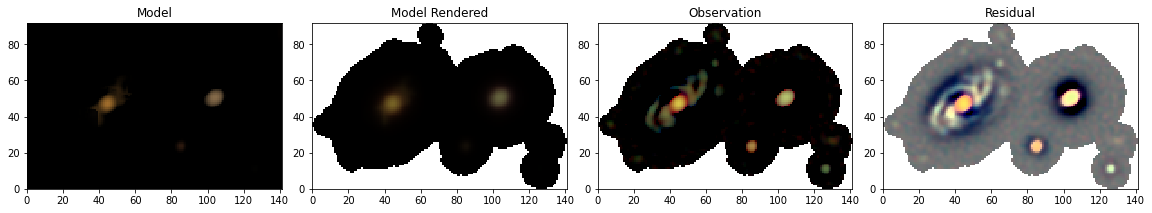

In [163]:
scarlet.display.show_scene(blend.sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()

0.24323405


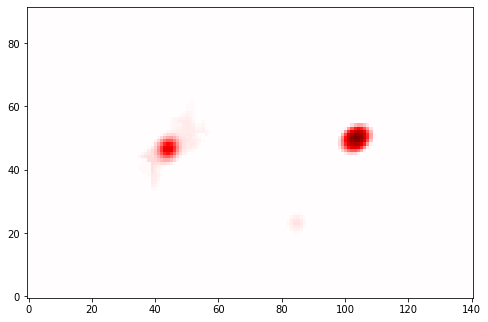

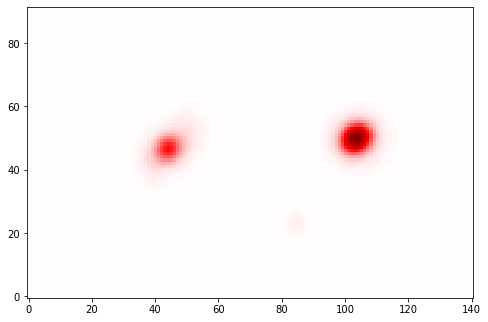

0.28647855


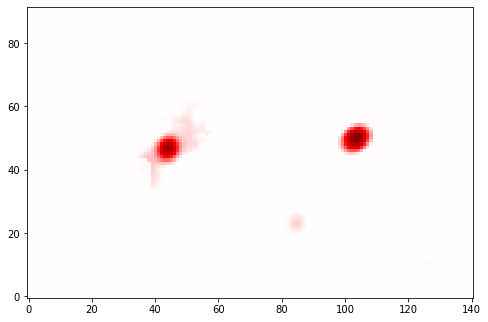

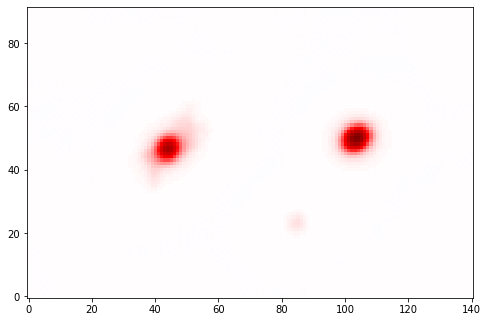

0.4066505


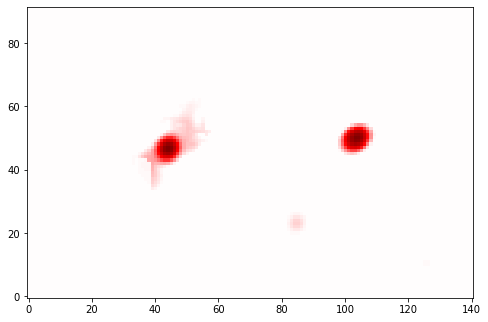

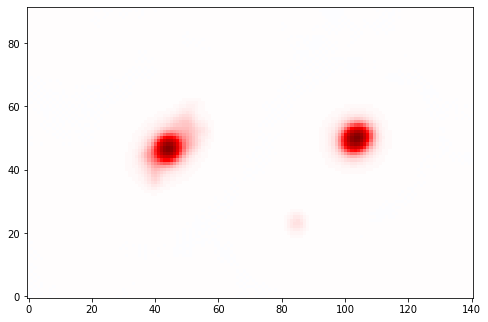

0.49603656


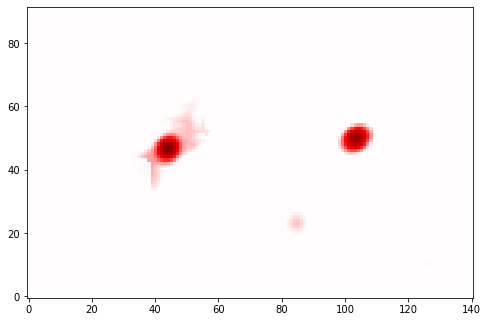

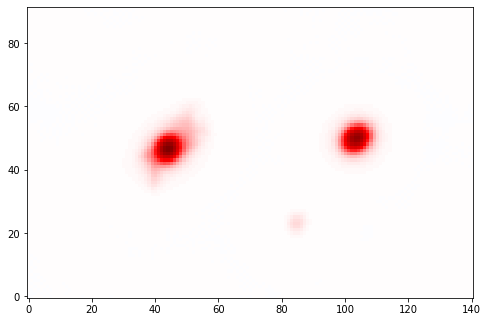

0.61897355


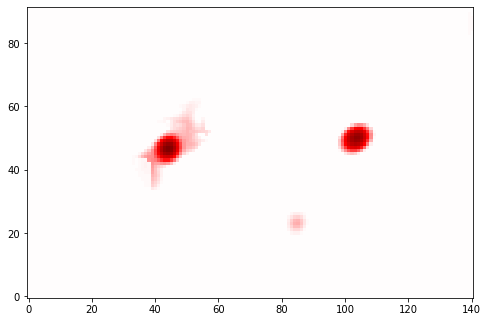

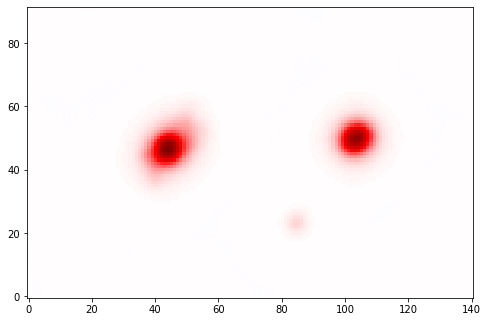

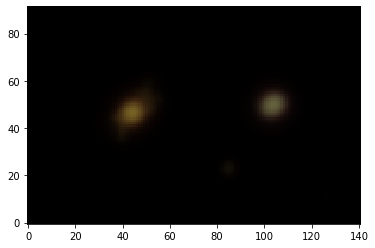

In [164]:
test = []
model = blend.get_model()
diff = observation.renderer.diff_kernel.image
for m, d in zip(model, diff):
    test.append(convolve(m, d, mode="same"))
    arcsinh_plot(m)
    print(np.max(m))
    plt.show()
    arcsinh_plot(test[-1])
    plt.show()
test = np.array(test)

rgb = scarlet.display.img_to_rgb(test, norm=norm)
plt.imshow(rgb, origin="lower")
plt.show()

In [165]:
%time blend.fit(100, e_rel=1e-4)

CPU times: user 5.21 s, sys: 170 ms, total: 5.38 s
Wall time: 5.38 s


(100, -41432.39460031499)

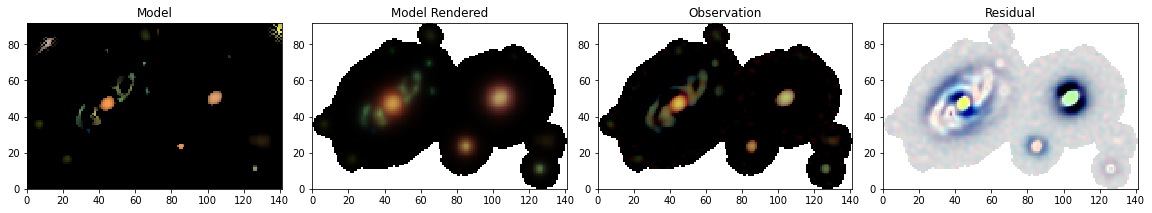

In [166]:
scarlet.display.show_scene(sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()

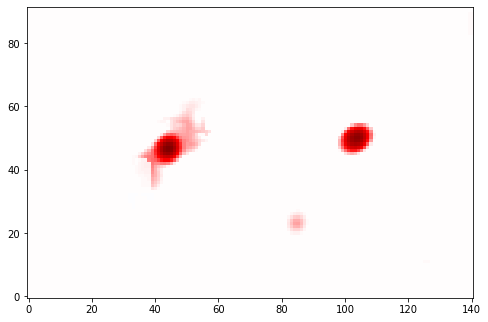

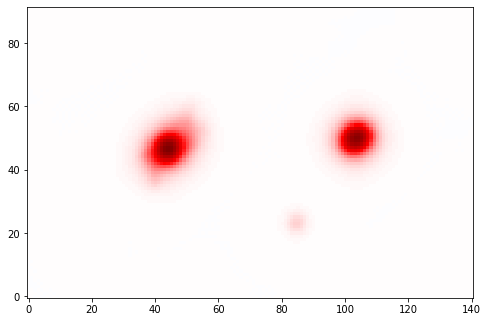

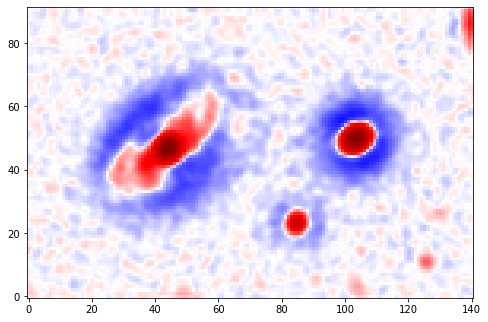

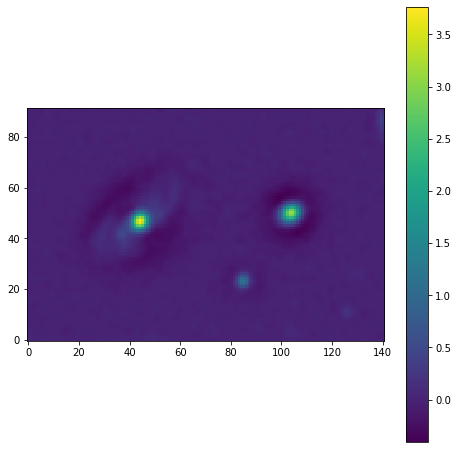

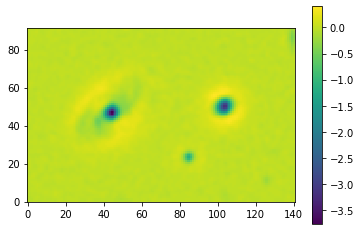

In [158]:
from scipy.signal import convolve

diff = observation.renderer.diff_kernel.image[-1]

w = wavelets[1,-1]

arcsinh_plot(model[-1])
arcsinh_plot(convolve(model[-1], diff, mode="same"))

arcsinh_plot(w)
_w = w.copy()
_w[_w<0] = 0
arcsinh_plot(convolve(_w, diff, mode="same"))

plt.imshow(w-model[-1], origin="lower")
plt.colorbar()
plt.show()

plt.imshow(model[-1]-w, origin="lower")
plt.colorbar()
plt.show()